<a href="https://colab.research.google.com/github/Edgar-IAH/MNIST/blob/main/MNIST_Practice_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from keras.datasets import mnist
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_validate, learning_curve, validation_curve
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, make_scorer
from sklearn.dummy import DummyClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_recall_curve, precision_recall_fscore_support
from sklearn.metrics import precision_score,recall_score,roc_auc_score,roc_curve


In [2]:
(X_train_raw, y_train), (X_test_raw, y_test) = mnist.load_data()
print('X_train_raw: ', X_train_raw.shape,X_train_raw.__class__)
print('y_train: ', y_train.shape,y_train.__class__)
print('X_test_raw: ', X_test_raw.shape)
print('y_test: ', y_test.shape)


11490434/11490434 [==============================] - 0s 0us/step
X_train_raw:  (60000, 28, 28) <class 'numpy.ndarray'>
y_train:  (60000,) <class 'numpy.ndarray'>
X_test_raw:  (10000, 28, 28)
y_test:  (10000,)


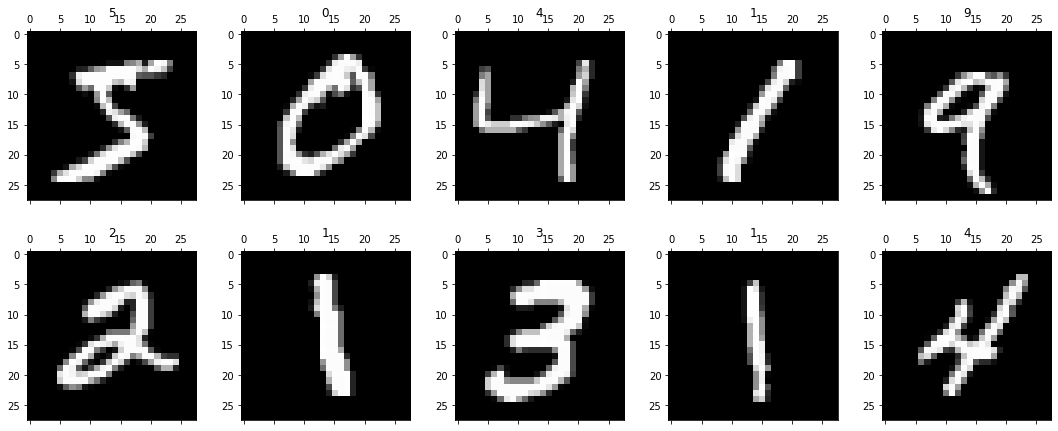

In [3]:

fig, axes = plt.subplots(2, 5, figsize=(15,6))
fig.tight_layout(h_pad=3)



for i in range(10):
  plt.gray()
  ax = plt.subplot(2, 5, i+1)
  ax.set_title(y_train[i])
  plt.matshow(X_train_raw[i],fignum=False)

plt.show()


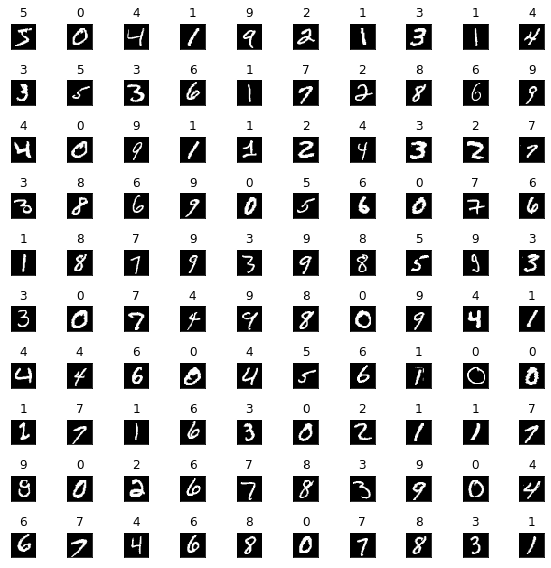

In [4]:

fig, axes = plt.subplots(10, 10, figsize=(8,8))
fig.tight_layout()

for i in range(100):
  plt.gray()
  ax = plt.subplot(10, 10, i+1)
  ax.set_title(y_train[i])
  plt.gca().axes.get_yaxis().set_visible(False)
  plt.gca().axes.get_xaxis().set_visible(False)
  plt.matshow(X_train_raw[i],fignum=False)

plt.show()


In [5]:
X_train = np.reshape(X_train_raw, (60000, 784))
X_test = np.reshape(X_test_raw, (10000, 784))
print('X_train: ', X_train.shape,X_train_raw.__class__)
print('X_test: ', X_test.shape,X_train_raw.__class__)


X_train:  (60000, 784) <class 'numpy.ndarray'>
X_test:  (10000, 784) <class 'numpy.ndarray'>


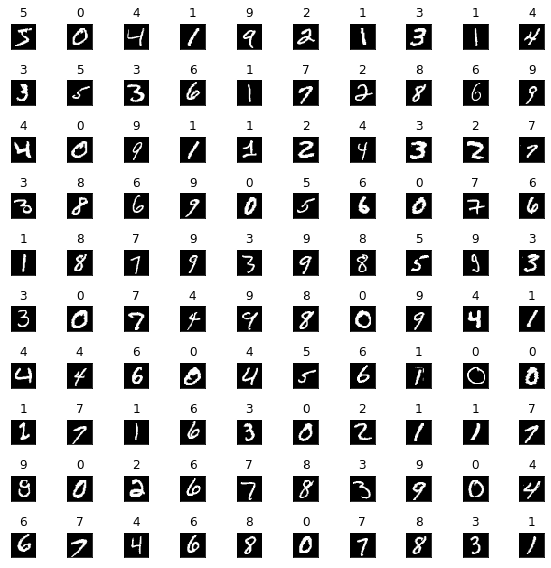

In [6]:
fig, axes = plt.subplots(10, 10, figsize=(8,8))
fig.tight_layout()

for i in range(100):
  plt.gray()
  ax = plt.subplot(10, 10, i+1)
  ax.set_title(y_train[i])
  plt.gca().axes.get_yaxis().set_visible(False)
  plt.gca().axes.get_xaxis().set_visible(False)
  imagen = np.zeros((28, 28))
  for r in range(28):
    for c in range(28):
      imagen[r,c] = X_train[i, r*28+c]
  plt.matshow(imagen,fignum=False)

plt.show()

In [7]:

modeloDummy = DummyClassifier(strategy='stratified')

modeloDummy.fit(X_train, y_train)       # entrenamos con los conjuntos de entrenamiento

predictions_train = modeloDummy.predict(X_train)
predictions_test = modeloDummy.predict(X_test)

print('===============================\nDUMMY REGRESSOR:\n===============================')
print('ENTRENAMIENTO:')
print('Accuracy : ', accuracy_score(y_train, predictions_train))
print('Precision: ', precision_score(y_train, predictions_train, average='micro'))
print('Recall:    ', recall_score(y_train, predictions_train, average='micro'))

print('PRUEBA:')
print('Accuracy : ', accuracy_score(y_test, predictions_test))
print('Precision: ', precision_score(y_test, predictions_test, average='micro'))
print('Recall:    ', recall_score(y_test, predictions_test, average='micro'))

DUMMY REGRESSOR:
ENTRENAMIENTO:
Accuracy :  0.10031666666666667
Precision:  0.10031666666666667
Recall:     0.10031666666666667
PRUEBA:
Accuracy :  0.1004
Precision:  0.1004
Recall:     0.1004


In [9]:
#model = MLPClassifier(max_iter=5000, hidden_layer_sizes=(15,15)) # Multi-layer perceptron (must increase number of iterations)
model = MLPClassifier()
cv = RepeatedKFold(n_splits=2, n_repeats=1, random_state=10) # k-folds cross-validation

# Metrics to evaluate model
metrics = {
    "accuracy": make_scorer(accuracy_score),
    "precision": make_scorer(precision_score, average='micro'),
    "recall": make_scorer(recall_score, average='micro'),
}

scores = cross_validate(model, X_train, y_train, scoring=metrics, cv=cv, return_train_score=True, n_jobs=-1)
print('ENTRENAMIENTO:')
print('mean accuracy: %.3f (%.4f)\nmean precision: %.3f (%.4f)\nmean recall: %.3f (%.4f)\n' % (
                                                                      np.mean(scores['train_accuracy']),
                                                                      np.std(scores['train_accuracy']),
                                                                      np.mean(scores['train_precision']),
                                                                      np.std(scores['train_precision']), 
                                                                      np.mean(scores['train_recall']),
                                                                      np.std(scores['train_recall']),
                                                                      ))
    
print('VALIDACION (interna al método de validación cruzada):')
print('mean accuracy: %.3f (%.4f)\nmean precision: %.3f (%.4f)\nmean recall: %.3f (%.4f)\n' % (
                                                                      np.mean(scores['test_accuracy']) ,
                                                                      np.std(scores['test_accuracy']),
                                                                      np.mean(scores['test_precision']),
                                                                      np.std(scores['test_precision']), 
                                                                      np.mean(scores['test_recall']),
                                                                      np.std(scores['test_recall']),
                                                                      ))

ENTRENAMIENTO:
mean accuracy: 0.990 (0.0012)
mean precision: 0.990 (0.0012)
mean recall: 0.990 (0.0012)

VALIDACION (interna al método de validación cruzada):
mean accuracy: 0.951 (0.0013)
mean precision: 0.951 (0.0013)
mean recall: 0.951 (0.0013)



In [11]:
pd.DataFrame(scores).style

,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall
0,51.646305,0.393155,0.951967,0.990733,0.951967,0.990733,0.951967,0.990733
1,65.124668,0.239027,0.949400,0.988333,0.949400,0.988333,0.949400,0.988333


In [14]:
# Results over test set
print('PRUEBA:')

# Fit best model and test it
model.fit(X_train, y_train) # fit model

predictions = model.predict(X_test) # Compute predictions over test set

print('accuracy_score: %.3f\nprecision_score: %.3f\nrecall_score: %.3f\n' % (
    accuracy_score(y_test, predictions),
    precision_score(y_test, predictions, average='micro'),
    recall_score(y_test, predictions, average='micro')
))

cm = confusion_matrix(y_test, predictions, labels=range(10))
print(cm)

PRUEBA:
accuracy_score: 0.969
precision_score: 0.969
recall_score: 0.969

[[ 969    0    1    2    0    1    3    2    2    0]
 [   0 1124    2    2    3    1    1    0    2    0]
 [   6    2 1002    6    3    0    0    7    5    1]
 [   1    1    8  986    0    3    0    8    3    0]
 [   4    1    0    0  947    0    7    1    6   16]
 [   4    1    0   18    0  845    8    2    9    5]
 [   6    3    4    0    8    4  929    0    4    0]
 [   2    2   11    5    2    0    0  996    3    7]
 [   4    1    5    9    2    3    0    3  942    5]
 [   2    4    1    9   16    1    0   13   10  953]]


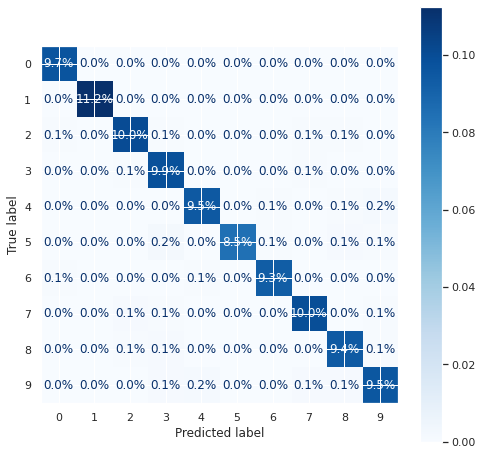

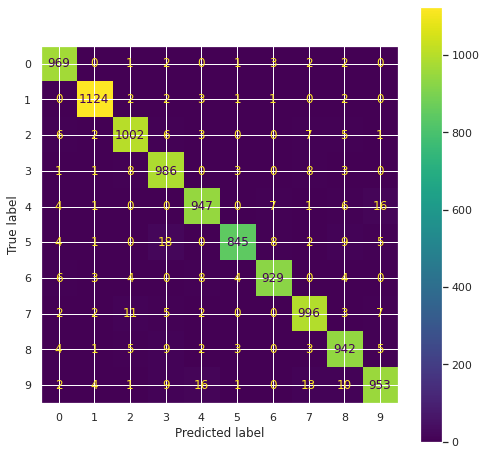

In [21]:

sns.set(rc={"figure.figsize": (8, 8)})
disp = ConfusionMatrixDisplay.from_predictions(y_test, predictions, cmap='Blues',  normalize='all', values_format= '.1%')
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm)
disp1.plot()
plt.show()

In [22]:
print(accuracy_score(y_test, predictions))
print(precision_score(y_test, predictions, average=None))
print(recall_score(y_test, predictions, average=None))

0.9693
[0.97094188 0.98683055 0.96905222 0.95081967 0.96534149 0.98484848
 0.97995781 0.96511628 0.95537525 0.96555218]
[0.98877551 0.99030837 0.97093023 0.97623762 0.96435845 0.94730942
 0.9697286  0.9688716  0.96714579 0.9444995 ]


Con el modelo entrenado, hagamos unas predicciones puntuales, visualizando entrada y salida:

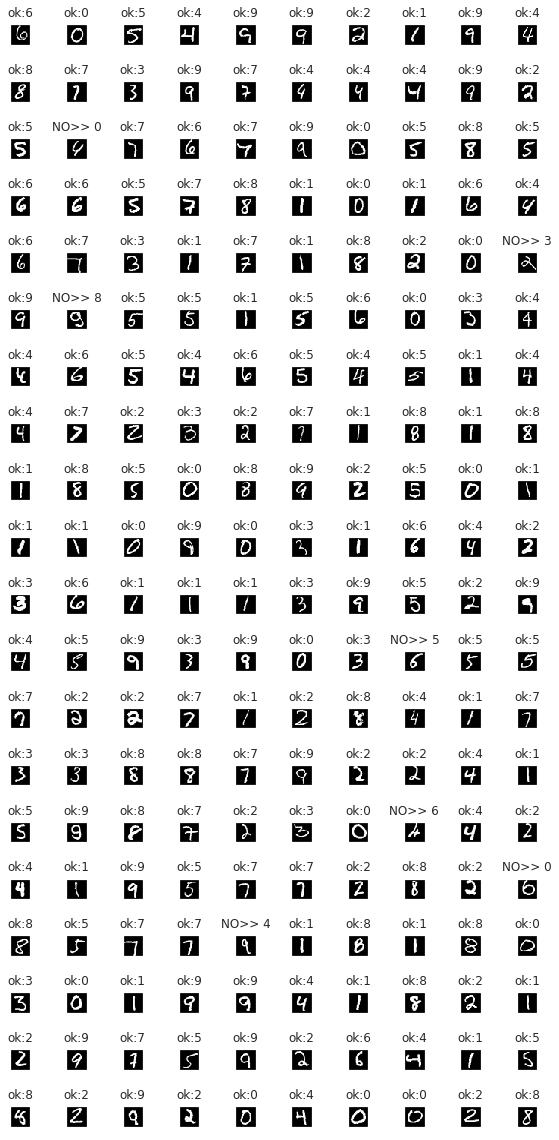

In [32]:
predictions = model.predict(X_test)

fig, axes = plt.subplots(20, 10, figsize=(8, 16))
fig.tight_layout()

for i in range(200):
  offset = 100
  plt.gray()
  ax = plt.subplot(20, 10, i+1)
  if predictions[offset+i] == y_test[offset+i]:
    label = 'ok:'
  else:
    label = 'NO>> '
  ax.set_title(label + str(predictions[offset+i]))
  plt.gca().axes.get_yaxis().set_visible(False)
  plt.gca().axes.get_xaxis().set_visible(False)
  imagen = np.zeros((28, 28))
  for r in range(28):
    for c in range(28):
      imagen[r,c] = X_test[offset+i, r*28+c]
  plt.matshow(imagen,fignum=False)

plt.show()

Por último, mostramos los primeros 100 números que ek modelo no pudo predecir correctamente. Se puede apreciar que, en general, están mal escritos!!

Aquí hay algunos de los errores:


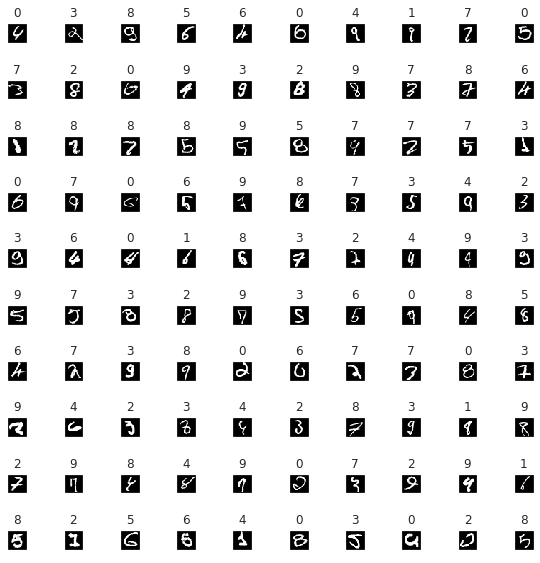

In [36]:
print("Aquí hay algunos de los errores:")
print("================================")

fig, axes = plt.subplots(10, 10, figsize=(8, 8))
fig.tight_layout()

i = 0
graficas = 0
offset = 0
while graficas < 100:

  if predictions[offset+i] != y_test[offset+i]:
    plt.gray()
    graficas = graficas + 1
    ax = plt.subplot(10, 10, graficas)
    ax.set_title(predictions[offset+i])
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.gca().axes.get_xaxis().set_visible(False)
    imagen = np.zeros((28, 28))
    for r in range(28):
      for c in range(28):
        imagen[r,c] = X_test[offset+i, r*28+c]
    plt.matshow(imagen,fignum=False)
  
  i = i + 1

plt.show()